<a href="https://colab.research.google.com/github/ZenaPoudel/Schiz_Detector/blob/main/Test_single_ON_MCIC_trained_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    Resize,
    ResizeWithPadOrCrop,
    LoadImage,
    Spacing,
    ScaleIntensity,
    Orientation, 
)
import torch
import torch.nn as nn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [77]:
image_path='/content/drive/MyDrive/schizophrenia_data/COBRE/schizconnect_COBRE_images_16224/COBRE/sub-A00023243/ses-20090101/anat/sub-A00023243_ses-20090101_acq-mprage_run-01_T1w.nii.gz'

In [78]:
state_dict_path='/content/best_metric_model_classification3d_array.pth'

In [79]:
image_label=1

In [80]:
model = nn.Sequential(
        nn.Conv3d(1, 32, [3,3,3], stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None),
        nn.ReLU(inplace=False),
        nn.Conv3d(32, 32, [3,3,3], stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None),
        torch.nn.ReLU(inplace=False),
        nn.MaxPool3d([3,3,3], stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False),
        nn.Dropout(p=0.3, inplace=False),
        nn.Conv3d(32, 64, [3,3,3], stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None),
        nn.ReLU(inplace=False),
        nn.Conv3d(64, 64, [3,3,3], stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None),
        torch.nn.ReLU(inplace=False),
        nn.MaxPool3d([3,3,3], stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False),
        nn.Dropout(p=0.3, inplace=False),
        nn.Flatten(start_dim=1, end_dim=- 1),
        nn.Linear(46656, 512, bias=True, device=None, dtype=None),
        nn.Dropout(p=0.3, inplace=False),
        nn.Linear(512, 2, bias=True, device=None, dtype=None),
        nn.Softmax(dim=1)
    )

if torch.cuda.is_available():
    model.cuda()

In [81]:
def last_conv_layer():
    last_conv_layer_name = list(filter(lambda x: isinstance(x, nn.Conv3d), model.modules()))[-1]
    return last_conv_layer_name

def forward_hook(module, input, output):
    activation.append(output)
def backward_hook(module, grad_in, grad_out):
    grad.append(grad_out[0])

last_conv_layer_name= last_conv_layer()
last_conv_layer_name.register_forward_hook(forward_hook)
last_conv_layer_name.register_backward_hook(backward_hook)
grad = []
activation = []

In [150]:
transforms = Compose([LoadImage(image_only=True), ScaleIntensity(), EnsureChannelFirst(), Orientation(axcodes='RAS'), Spacing(pixdim=(2,2,2)), ResizeWithPadOrCrop(spatial_size=((99,99,99)))])

image = transforms(image_path)
image = image.unsqueeze(0)
image = image.cuda()

In [151]:
image.size()

torch.Size([1, 1, 99, 99, 99])

In [152]:
label_pred = image_label
model = model.cuda()

In [153]:
device = torch.device("cuda" )

In [154]:
model.load_state_dict(torch.load(state_dict_path))

model.eval()
predicted = model(image)

predicted

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1113: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


tensor([[0.4929, 0.5071]], device='cuda:0', grad_fn=<AliasBackward0>)

In [155]:
pred_labels = [[0,1]]#because our label is 1
pred_label = np.array(pred_labels)
pred_labels = torch.from_numpy(pred_label)
pred_labels = pred_labels.float().to(device)



In [156]:
loss_function = torch.nn.BCELoss()

pred_loss = loss_function(predicted, pred_labels)

model.zero_grad()

pred_loss.backward()




In [159]:
grads = grad[0].cpu().data.numpy().squeeze()
fmap = activation[0].cpu().data.numpy().squeeze()

tmp = grads.reshape([grads.shape[0],-1])
weights = np.mean(tmp, axis=1)


cam = np.zeros(grads.shape[1:])

for i,w in enumerate(weights):
    cam += w*fmap[i,:]
cam = (cam>0)*cam
cam = cam/cam.max()*255

cam = torch.from_numpy(cam)
cam = cam.unsqueeze(0)
cam = Spacing(pixdim=(2,2,2))(cam)
cam = Resize(spatial_size=(99,99,99))(cam)

In [163]:
cam=cam.squeeze(0)

In [164]:
cam.size()

torch.Size([99, 99, 99])

In [165]:
import matplotlib.pyplot as plt

In [166]:
img=image.squeeze(0)
img=img.squeeze(0)
img=img.squeeze(0)

In [167]:
img.size()

torch.Size([99, 99, 99])

In [210]:
heat_map = 0.000001*cam + 0.9*img.cpu()

In [203]:
heat_map.shape

torch.Size([99, 99, 99])

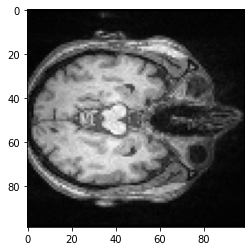

In [197]:
test_brain= img[:,:,45].cpu()
plt.imshow(test_brain,plt.cm.gray)
plt.show()

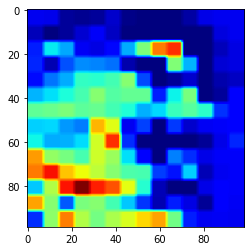

In [208]:
test_cam= cam[:,:,45].cpu()
plt.imshow(test_cam,cmap='jet')
plt.show()

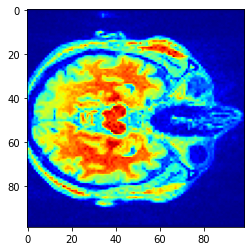

In [211]:
test_heat= heat_map[:,:,45].cpu()
plt.imshow(test_heat,cmap='jet')
plt.show()